# Relax Takehome Challenge
## Goal: Identify which factors predict future user adoption with "adopted user" defined as user who has logged into product on three separate days in at least one seven-day period

# Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#model assessment
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


# Load Data

In [2]:
users = pd.read_csv('takehome_users.csv', encoding='latin1')
engagement = pd.read_csv('takehome_user_engagement.csv')

# Exploratory Data Analysis

In [3]:
#users.head()

In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [5]:
#engagement.head()

In [6]:
#engagement.info()

In [7]:
grouped_engagement = engagement.groupby('user_id').count().sort_values(by = 'visited', ascending = False)

In [8]:
#check total time period covered by engagement df, 
engagement_first = engagement['time_stamp'].min()
engagement_last = engagement['time_stamp'].max()
print("first engagement: ", engagement_first, ", last engagement: ", engagement_last )

first engagement:  2012-05-31 08:20:06 , last engagement:  2014-06-06 14:58:50


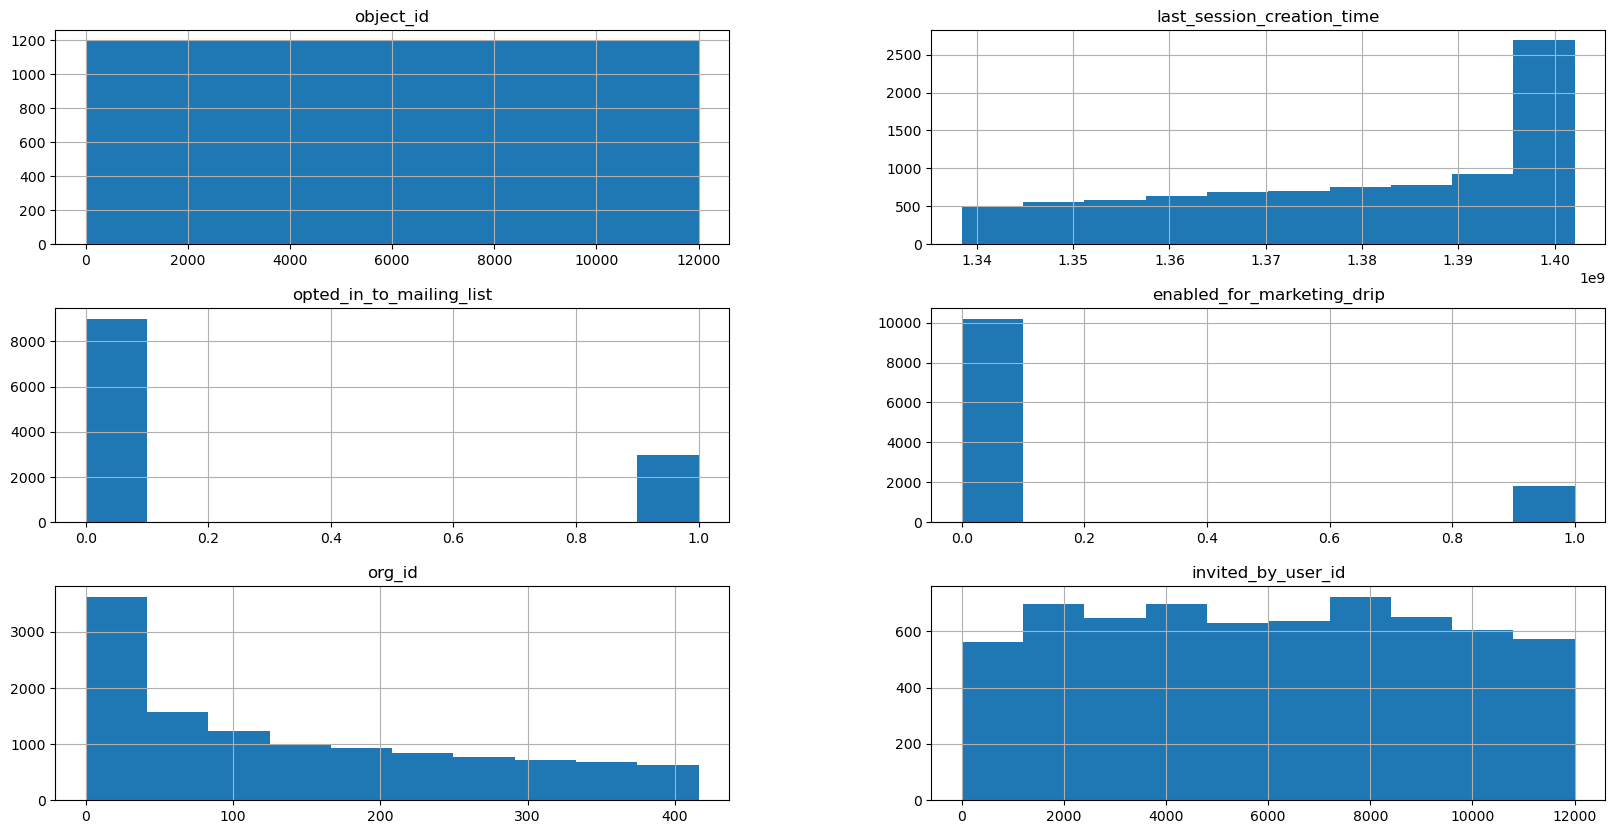

In [9]:
#look at distributions of user info columns
users.hist(figsize = (20,10));

# Data Cleaning

## Check for duplicates

In [10]:
mask = grouped_engagement['time_stamp'] != grouped_engagement['visited']
duplicates = grouped_engagement[mask]
#duplicates

### There appear to be no duplicates, with each user's visit mapping to a unique timestamp.

### Convert object datatype to datetime format

# Data Preprocessing

In [11]:
#Returning to the engagement dataset, we see that our time stamp column is an object 
print(engagement['time_stamp'].dtype)

object


In [12]:
#convert to datetime
engagement['time_stamp']= pd.to_datetime(engagement['time_stamp'])
print(engagement['time_stamp'].dtype)

datetime64[ns]


# Feature Engineering

## Use rolling window to find list of users who meet "adopter" criteria. 

In [13]:
#set index
engagement.set_index('time_stamp', drop = True, inplace = True)
#engagement.head()

In [14]:
#sort values
engagement.sort_values(by = ['user_id','time_stamp'], inplace = True)
#engagement.head(30)

In [15]:
# Check the rolling sum calculation and structure before filtering
check_rolling = engagement.groupby('user_id').rolling(window='7D').visited.sum()
#print(check_rolling.head(20));

In [16]:
# Apply filter for adopted criteria
adopted = check_rolling[check_rolling >= 3]

In [17]:
# Reset index to make 'user_id' and 'time_stamp' regular columns again
adopted_users = adopted.reset_index()
adopted_users;

In [18]:
#Group by 'user_id' and get the maximum 'visited' count
adopted_users_max_visits = adopted_users.groupby('user_id').visited.max().reset_index()
#adopted_users_max_visits

In [19]:
adopted_users_max_visits.sort_values(by='user_id', inplace=True)
#print(adopted_users_max_visits['user_id'])

## Now we've identified the user id numbers that fit our adoption criteria. 
## Next, we will merge these results with the users df 

In [20]:
#Initialize column 'is_adopter' in the users df to 0
users['is_adopter'] = 0
#print(users['is_adopter'].head());

In [21]:
#Create new df from adopters with user id
#use [[]] so create df and not series
adopters = adopted_users_max_visits[['user_id']]
#add new column set to 1
adopters['is_adopter_y'] = 1
#adopters.head()

In [22]:
#merge users and adopters dfs
merged_df = users.merge(adopters, left_on = 'object_id', right_on = 'is_adopter_y', how = 'left')

In [23]:
#fill NaN values with 0
users['is_adopter'] = merged_df['is_adopter_y'].fillna(0).astype(int)

users

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopter
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,1
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,1
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,1
...,...,...,...,...,...,...,...,...,...,...,...
11995,11996,2013-09-06 06:14:15,Meier Sophia,SophiaMeier@gustr.com,ORG_INVITE,1.378448e+09,0,0,89,8263.0,0
11996,11997,2013-01-10 18:28:37,Fisher Amelie,AmelieFisher@gmail.com,SIGNUP_GOOGLE_AUTH,1.358275e+09,0,0,200,NaN,0
11997,11998,2014-04-27 12:45:16,Haynes Jake,JakeHaynes@cuvox.de,GUEST_INVITE,1.398603e+09,1,1,83,8074.0,0
11998,11999,2012-05-31 11:55:59,Faber Annett,mhaerzxp@iuxiw.com,PERSONAL_PROJECTS,1.338638e+09,0,0,6,NaN,0


In [24]:
users['is_adopter']
print(users['is_adopter'].nunique());

2


In [25]:
#convert categorical column to binary using one hot encoding`
users_encoded = pd.get_dummies(users, columns = ['creation_source'])

for column in users_encoded.columns:
    if column.startswith('creation_source'):
        users_encoded[column] = users_encoded[column].astype(int)

In [26]:
#users_encoded['creation_time'].dtype

In [27]:
#convert creation time column from time stamp to days from creation
users_encoded['creation_time'] = pd.to_datetime(users_encoded['creation_time'])
reference_date = users_encoded['creation_time'].min()
users_encoded['days_from_creation'] = (users_encoded['creation_time']-reference_date).dt.days
users_encoded.head()

,object_id,creation_time,name,email,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,is_adopter,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,days_from_creation
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,1.398139e+09,1,0,11,10803.0,1,1,0,0,0,0,691
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,1.396238e+09,0,0,1,316.0,1,0,1,0,0,0,533
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,1.363735e+09,0,0,94,1525.0,1,0,1,0,0,0,292
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,1.369210e+09,0,0,1,5151.0,1,1,0,0,0,0,355
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,1.358850e+09,0,0,193,5240.0,1,1,0,0,0,0,231


In [28]:
users['invited_by_user'] = users['invited_by_user_id'].notna().astype(int)


In [29]:
numeric_users = users_encoded.drop(['object_id', 'creation_time', 'name', 'email', 'invited_by_user_id', 'org_id', 'invited_by_user_id', 'last_session_creation_time'], axis = 1)
numeric_users.columns

Index(['opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'is_adopter',
       'creation_source_GUEST_INVITE', 'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH', 'days_from_creation'],
      dtype='object')

In [30]:
#pairplot = sns.pairplot(numeric_users, hue = 'is_adopter', palette = 'bright')

In [31]:
numeric_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column                              Non-Null Count  Dtype
---  ------                              --------------  -----
 0   opted_in_to_mailing_list            12000 non-null  int64
 1   enabled_for_marketing_drip          12000 non-null  int64
 2   is_adopter                          12000 non-null  int64
 3   creation_source_GUEST_INVITE        12000 non-null  int64
 4   creation_source_ORG_INVITE          12000 non-null  int64
 5   creation_source_PERSONAL_PROJECTS   12000 non-null  int64
 6   creation_source_SIGNUP              12000 non-null  int64
 7   creation_source_SIGNUP_GOOGLE_AUTH  12000 non-null  int64
 8   days_from_creation                  12000 non-null  int64
dtypes: int64(9)
memory usage: 843.9 KB


# Predictive Modeling

## Logistic Regression Model

In [32]:
#use logistic regression model
X = numeric_users.drop('is_adopter', axis = 1)
y = users['is_adopter']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = .3, random_state = 42)
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred = model_lr.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93      3113
           1       0.00      0.00      0.00       487

    accuracy                           0.86      3600
   macro avg       0.43      0.50      0.46      3600
weighted avg       0.75      0.86      0.80      3600



/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/anooshmoutafian/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

## Random Forest Model

In [33]:
#random forest model
clf_rf = RandomForestClassifier(n_estimators = 100, random_state = 42, n_jobs=-1)
clf_rf.fit(X_train, y_train)
y_predict = clf_rf.predict(X_test)
print(classification_report(y_test, y_predict))

# Feature Importance

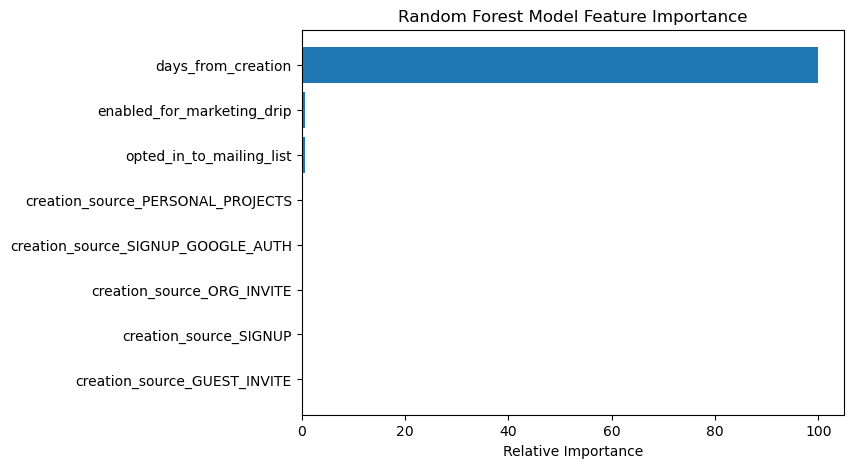

In [35]:
feature_importance = clf_rf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)

pos = np.arange(sorted_idx.shape[0]) + .5

sorted_idx.size
plt.figure(figsize=(7,5))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Model Feature Importance')
plt.show();

# Conclusion:
The column 'days_from_creation' appears to be the most relevant feature in prediction of users who will "adopt", with adoption being defined as at least three logins in at least one consecutive seven-day period. 